In [1]:
import sys
sys.path.insert(0,'..')

In [84]:
from dataset import ASODataset
from graph_fn import single_graph_batch
from trainer import Trainer
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
import torch
from torch_geometric.loader import DataLoader
from models import *
import matplotlib.pyplot as plt
import numpy as np

In [94]:
#hyperparameters
LEARNING_RATE = 0.01
BATCH_SIZE = 16
NODE_INPUT_SIZE = 14
OUTPUT_SIZE_BEFORE_POOL = 20
NODE_HIDDEN_SIZE = 50
EPOCHS = 50
DROP_OUT = 0.3
BOND_ATTR = 5

In [95]:
a = ASODataset(single_graph_batch)
train_loaders = []
val_loaders = []
for i in range(5):
    train_data, val_data = a.sample_test_data_catalyst_only(10,2,2)
    train_loaders.append(DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True))
    val_loaders.append(DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False))

In [96]:
class GNNModel_TransformerConv(nn.Module):
    #uses bond features as well
    #for data with ligand and reactants put in the same graph
    def __init__(self, d_in, d_hidden, d_out, edge_dim, num_layers=2, dp_rate=0, **kwargs):
        super().__init__()
        graph_layers = []
        in_channels, out_channels = d_in, d_hidden
        for l_idx in range(num_layers-1):
            graph_layers += [
                geom_nn.TransformerConv(-1, out_channels, dropout=DROP_OUT, edge_dim=edge_dim, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)]
            in_channels = d_hidden
        graph_layers += [geom_nn.TransformerConv(-1, d_out, dropout=DROP_OUT, edge_dim=edge_dim, **kwargs)]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.head = nn.Sequential(
            nn.Dropout(dp_rate),
            nn.Linear(d_out, 10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    #glob_vecs are the one hot encoding of reactants
    def forward(self, x, edge_index, edge_attr, batch_idx):
        for l in self.graph_layers:
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index.long(), edge_attr=edge_attr)
            else:
                x = l(x)
        x = geom_nn.global_mean_pool(x, batch_idx)
        x = self.head(x)
        return x

In [97]:
device = torch.device('cuda')
model = GNNModel_TransformerConv(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, BOND_ATTR, num_layers=3, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.95)

In [ ]:
t = Trainer(model, device, optimizer, scheduler, glob_v= False)
t.train(train_loaders[i], val_loaders[i], nn.BCELoss, EPOCHS)

Epoch: 001, Train Loss: 0.5250, Test Loss: 0.4698, Train MAE: 0.1220, Test MAE: 0.1414, , Train R2: 0.0039, Test R2: -0.0018
Epoch: 002, Train Loss: 0.5186, Test Loss: 0.4755, Train MAE: 0.1188, Test MAE: 0.1503, , Train R2: 0.1061, Test R2: -0.0724
Epoch: 003, Train Loss: 0.5010, Test Loss: 0.4745, Train MAE: 0.0932, Test MAE: 0.1401, , Train R2: 0.3863, Test R2: -0.0701
Epoch: 004, Train Loss: 0.4994, Test Loss: 0.4687, Train MAE: 0.0850, Test MAE: 0.1263, , Train R2: 0.4227, Test R2: 0.0064
Epoch: 005, Train Loss: 0.4910, Test Loss: 0.4653, Train MAE: 0.0804, Test MAE: 0.1374, , Train R2: 0.5784, Test R2: 0.0482
Epoch: 006, Train Loss: 0.4809, Test Loss: 0.4394, Train MAE: 0.0624, Test MAE: 0.1102, , Train R2: 0.7052, Test R2: 0.3728
Epoch: 007, Train Loss: 0.4830, Test Loss: 0.4652, Train MAE: 0.0665, Test MAE: 0.1338, , Train R2: 0.7014, Test R2: 0.0353
Epoch: 008, Train Loss: 0.4781, Test Loss: 0.4732, Train MAE: 0.0580, Test MAE: 0.1447, , Train R2: 0.7565, Test R2: -0.1097
Epoc

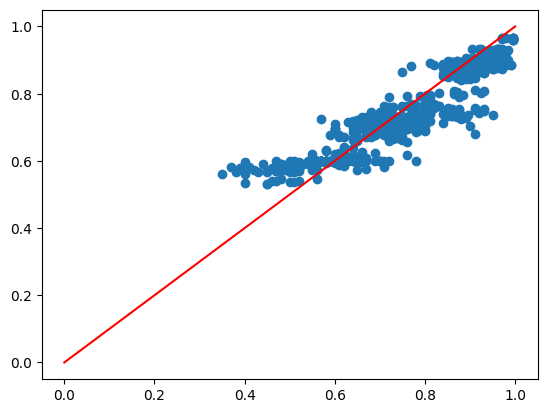

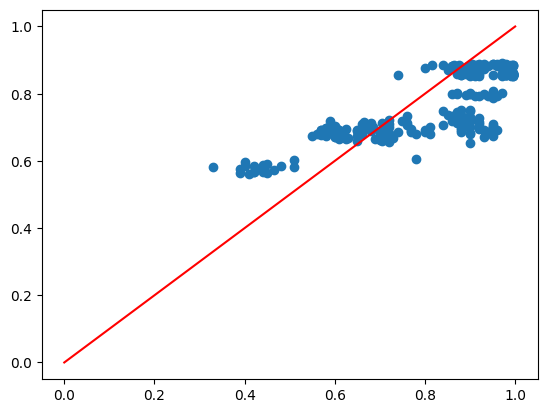

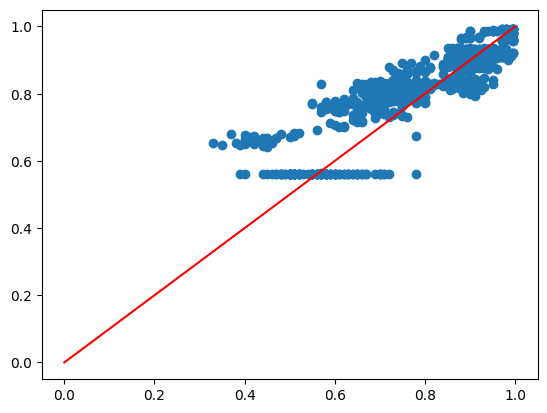

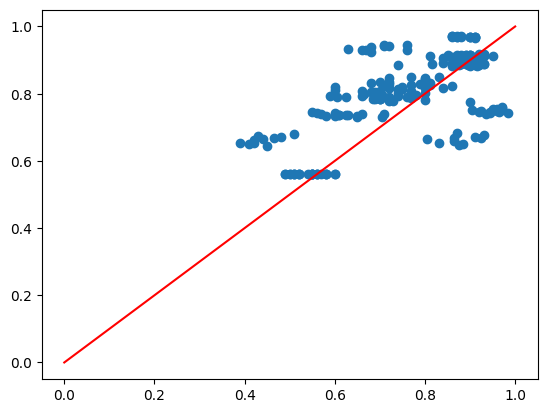

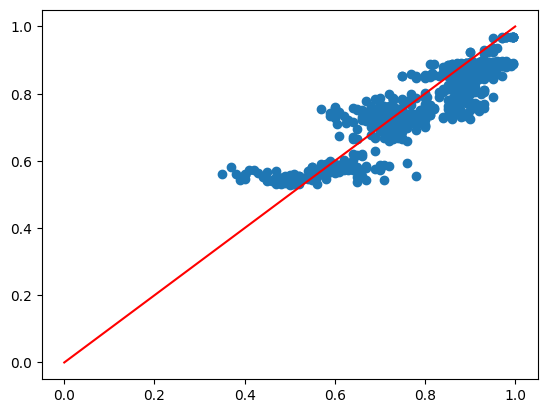

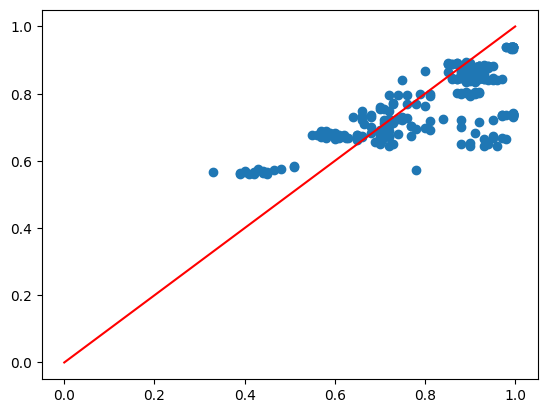

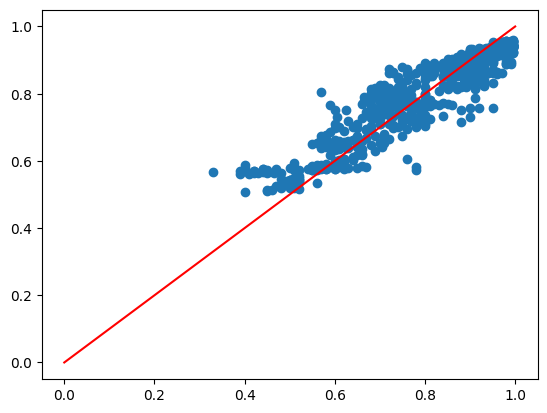

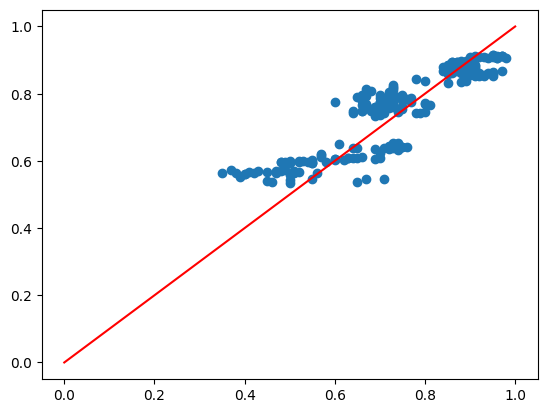

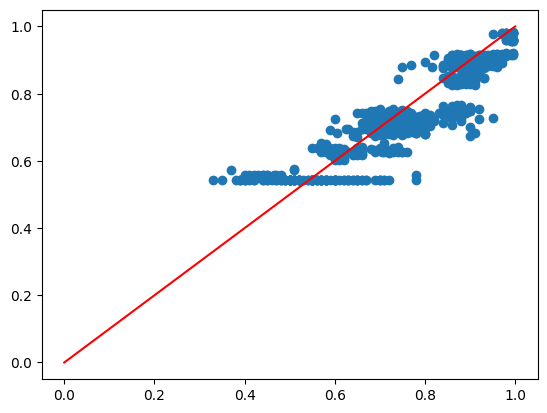

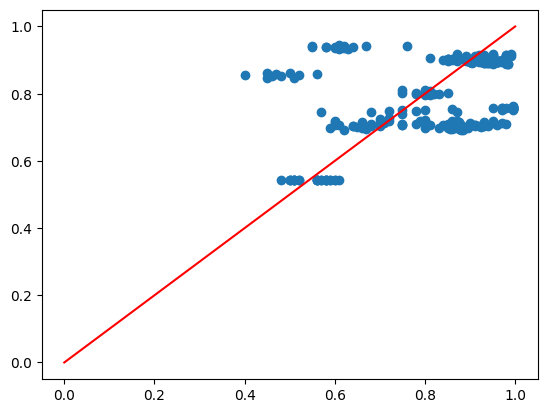

In [98]:
train_loss = np.zeros(50)
val_loss = np.zeros(50)
for i in range(5):
    device = torch.device('cuda')
    model = GNNModel_TransformerConv(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, BOND_ATTR, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    trainer = Trainer(model, device, optimizer, scheduler, glob_v= False)
    trainer.train(train_loaders[i], val_loaders[i], nn.BCELoss, EPOCHS)
    train_loss = np.add(train_loss, trainer.log["train_loss"])
    val_loss = np.add(val_loss, trainer.log["val_loss"])
tr_train_loss = train_loss / 5
tr_val_loss = val_loss / 5

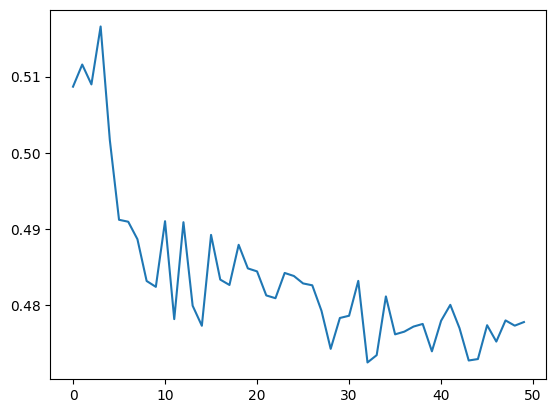

In [99]:
plt.plot(range(50), tr_val_loss)

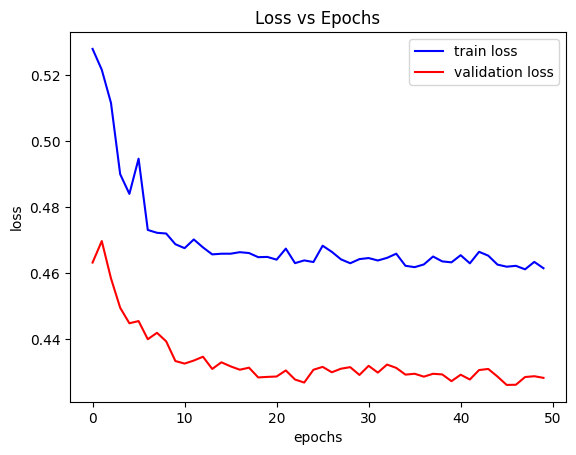

In [39]:
t.plot_log()

In [51]:
class GNNModel_ChebConv(nn.Module):
    #uses bond features as well
    #for data with ligand and reactants put in the same graph
    def __init__(self, d_in, d_hidden, d_out, edge_dim, num_layers=4, dp_rate=0, **kwargs):
        super().__init__()
        graph_layers = []
        in_channels, out_channels = d_in, d_hidden
        for l_idx in range(num_layers-1):
            graph_layers += [
                geom_nn.ChebConv(in_channels, out_channels, K=12, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)]
            in_channels = d_hidden
        graph_layers += [geom_nn.ChebConv(in_channels, d_out, K=12, **kwargs)]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.head = nn.Sequential(
            nn.Dropout(dp_rate),
            nn.Linear(d_out, 10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    #glob_vecs are the one hot encoding of reactants
    def forward(self, x, edge_index, edge_attr, batch_idx):
        for l in self.graph_layers:
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index.long())
            else:
                x = l(x)
        x = geom_nn.global_mean_pool(x, batch_idx)
        x = self.head(x)
        return x

In [57]:
#hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NODE_INPUT_SIZE = 14
OUTPUT_SIZE_BEFORE_POOL = 20
NODE_HIDDEN_SIZE = 50
EPOCHS = 50
DROP_OUT = 0.3
BOND_ATTR = 5

In [61]:
train_loss = np.zeros(50)
val_loss = np.zeros(50)
for i in range(5):
    device = torch.device('cuda')
    model = GNNModel_ChebConv(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, BOND_ATTR, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.8)
    t = Trainer(model, device, optimizer, scheduler, glob_v= False)
    t.train(train_loaders[i], val_loaders[i], nn.BCELoss, EPOCHS)
    train_loss = np.add(train_loss, t.log["train_loss"])
    val_loss = np.add(val_loss, t.log["val_loss"])
tr_train_loss = train_loss / 5
tr_val_loss = val_loss / 5

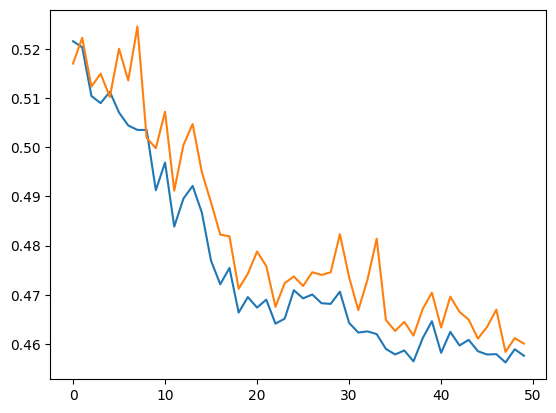

In [101]:
plt.plot(range(50), GINEConv_train_loss)
plt.plot(range(50), GINEConv_val_loss)

Epoch: 001, Train Loss: 0.5252, Test Loss: 0.4667, Train MAE: 0.1226, Test MAE: 0.1389, , Train R2: 0.0025, Test R2: 0.0337
Epoch: 002, Train Loss: 0.5332, Test Loss: 0.4955, Train MAE: 0.1365, Test MAE: 0.1731, , Train R2: -0.1373, Test R2: -0.3507
Epoch: 003, Train Loss: 0.5247, Test Loss: 0.4655, Train MAE: 0.1206, Test MAE: 0.1352, , Train R2: 0.0110, Test R2: 0.0421
Epoch: 004, Train Loss: 0.5234, Test Loss: 0.4752, Train MAE: 0.1251, Test MAE: 0.1513, , Train R2: 0.0323, Test R2: -0.0687
Epoch: 005, Train Loss: 0.5232, Test Loss: 0.4766, Train MAE: 0.1252, Test MAE: 0.1530, , Train R2: 0.0372, Test R2: -0.0887
Epoch: 006, Train Loss: 0.5266, Test Loss: 0.4851, Train MAE: 0.1292, Test MAE: 0.1626, , Train R2: -0.0188, Test R2: -0.2037
Epoch: 007, Train Loss: 0.5231, Test Loss: 0.4736, Train MAE: 0.1239, Test MAE: 0.1486, , Train R2: 0.0351, Test R2: -0.0485
Epoch: 008, Train Loss: 0.5231, Test Loss: 0.4774, Train MAE: 0.1252, Test MAE: 0.1540, , Train R2: 0.0377, Test R2: -0.0969


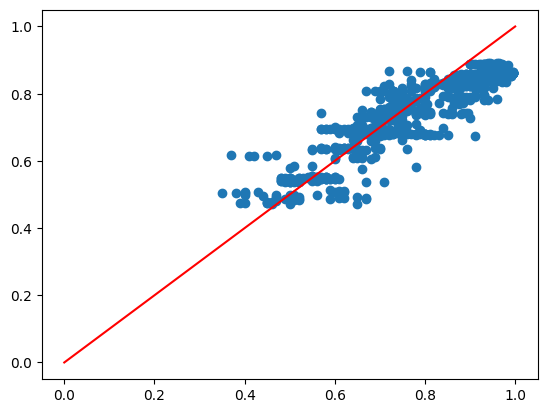

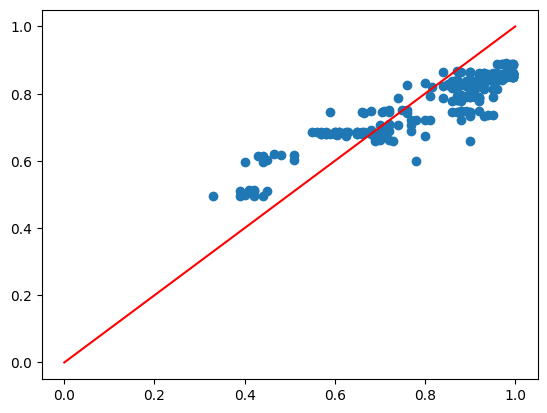

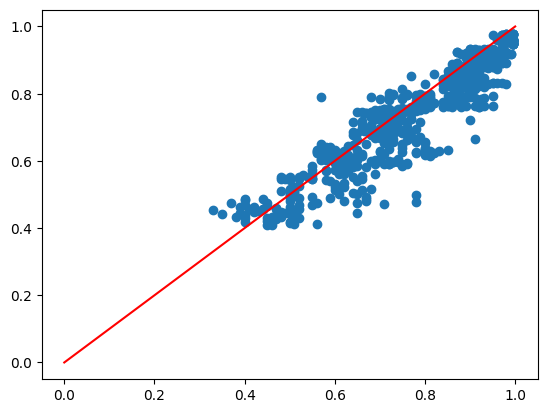

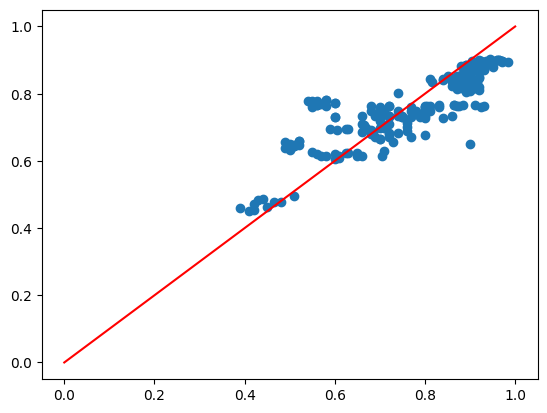

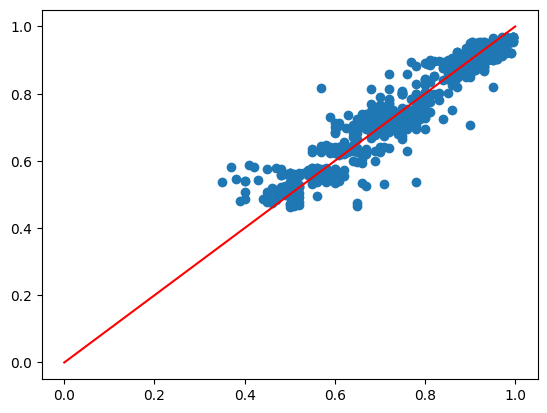

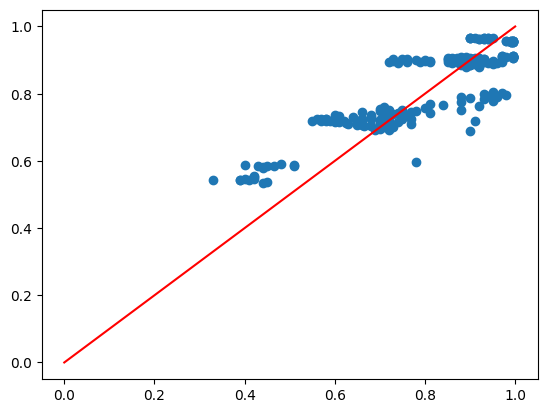

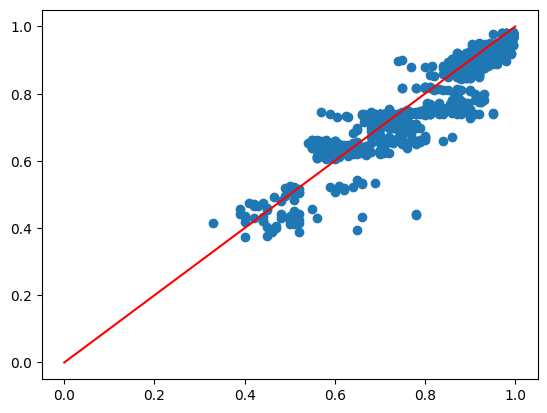

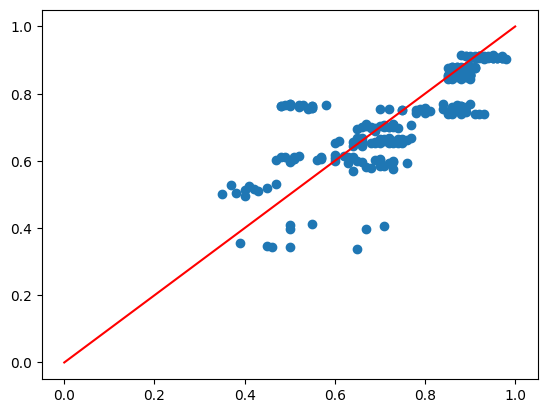

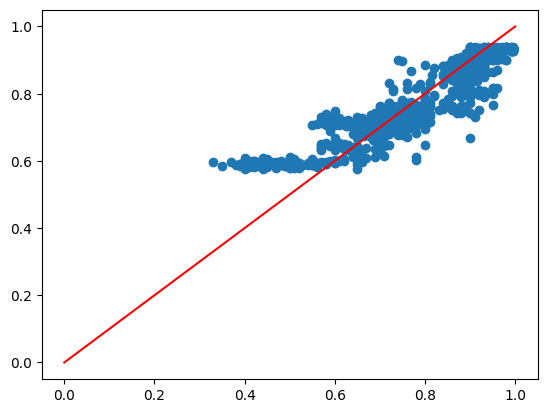

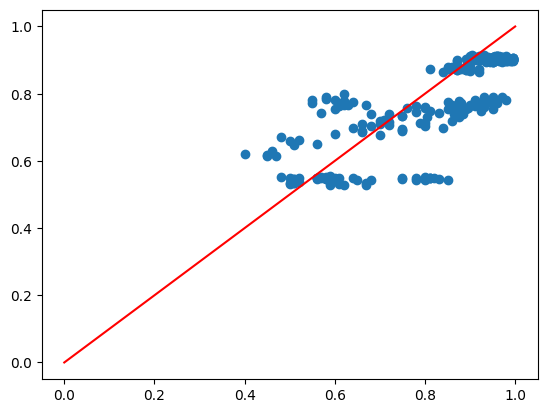

In [100]:
train_loss = np.zeros(50)
val_loss = np.zeros(50)
for i in range(5):
    device = torch.device('cuda')
    model = GNNModel_sg_edge_attr(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, BOND_ATTR, num_layers=3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.8)
    t = Trainer(model, device, optimizer, scheduler, glob_v= False)
    t.train(train_loaders[i], val_loaders[i], nn.BCELoss, EPOCHS)
    train_loss = np.add(train_loss, t.log["train_loss"])
    val_loss = np.add(val_loss, t.log["val_loss"])
GINEConv_train_loss = train_loss / 5
GINEConv_val_loss = val_loss / 5

Epoch: 001, Train Loss: 0.5362, Test Loss: 0.4941, Train MAE: 0.1493, Test MAE: 0.1405, , Train R2: -0.1454, Test R2: -0.7014
Epoch: 002, Train Loss: 0.5234, Test Loss: 0.4698, Train MAE: 0.1338, Test MAE: 0.1156, , Train R2: 0.0447, Test R2: -0.1058
Epoch: 003, Train Loss: 0.5166, Test Loss: 0.4573, Train MAE: 0.1226, Test MAE: 0.0970, , Train R2: 0.1322, Test R2: 0.1599
Epoch: 004, Train Loss: 0.5095, Test Loss: 0.4586, Train MAE: 0.1187, Test MAE: 0.0981, , Train R2: 0.2418, Test R2: 0.1371
Epoch: 005, Train Loss: 0.4927, Test Loss: 0.4535, Train MAE: 0.0968, Test MAE: 0.0868, , Train R2: 0.4792, Test R2: 0.2320
Epoch: 006, Train Loss: 0.4905, Test Loss: 0.4481, Train MAE: 0.0834, Test MAE: 0.0754, , Train R2: 0.4664, Test R2: 0.3265
Epoch: 007, Train Loss: 0.4741, Test Loss: 0.4466, Train MAE: 0.0680, Test MAE: 0.0783, , Train R2: 0.7377, Test R2: 0.3830
Epoch: 008, Train Loss: 0.4666, Test Loss: 0.4363, Train MAE: 0.0502, Test MAE: 0.0640, , Train R2: 0.8103, Test R2: 0.5610
Epoch

array([0.45784023, 0.03287451, 0.917741  , 0.42760313, 0.04809394,
       0.72960413])

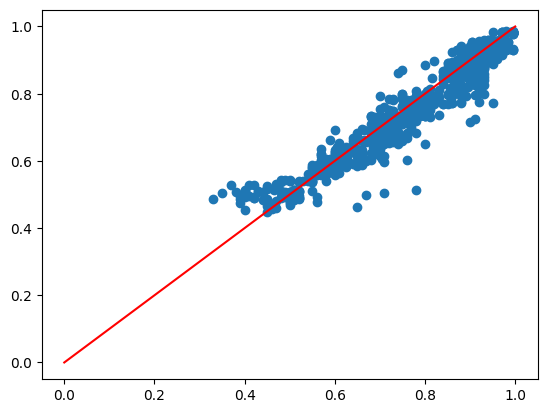

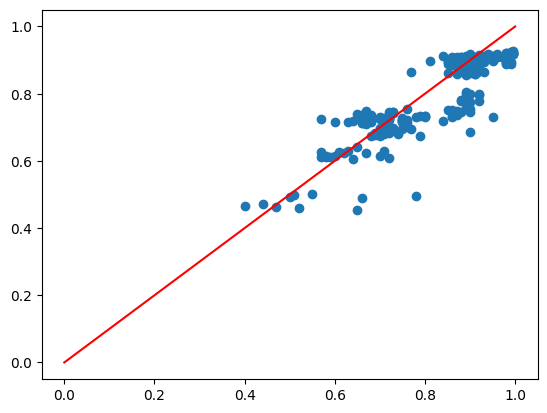

In [62]:
t2 = Trainer(model, device, optimizer, scheduler, glob_v= False)
t2.train(train_loader, val_loader, nn.BCELoss, EPOCHS)

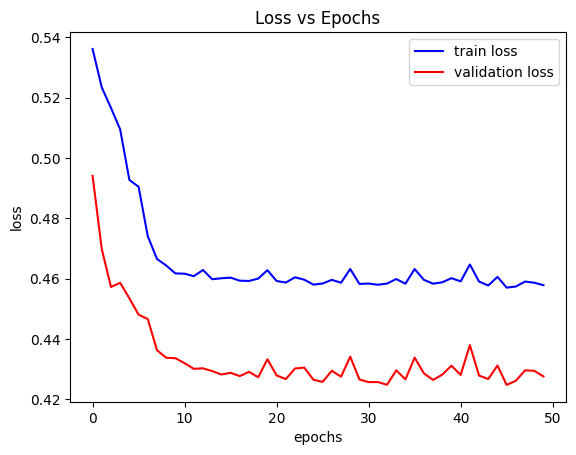

In [63]:
t2.plot_log()

In [70]:
#hyperparameters
LEARNING_RATE = 0.01
BATCH_SIZE = 16
NODE_INPUT_SIZE = 14
OUTPUT_SIZE_BEFORE_POOL = 20
NODE_HIDDEN_SIZE = 50
EPOCHS = 50
DROP_OUT = 0.3
BOND_ATTR = 5

device = torch.device('cuda')
model = GNNModel_sg_edge_attr(NODE_INPUT_SIZE, NODE_HIDDEN_SIZE, 
                      OUTPUT_SIZE_BEFORE_POOL, BOND_ATTR, num_layers=3, dp_rate=DROP_OUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.6)

Epoch: 001, Train Loss: 0.5270, Test Loss: 0.4643, Train MAE: 0.1325, Test MAE: 0.1077, , Train R2: -0.0058, Test R2: 0.0095
Epoch: 002, Train Loss: 0.5295, Test Loss: 0.4653, Train MAE: 0.1275, Test MAE: 0.0961, , Train R2: -0.0373, Test R2: -0.0108
Epoch: 003, Train Loss: 0.5386, Test Loss: 0.4981, Train MAE: 0.1178, Test MAE: 0.1067, , Train R2: -0.0104, Test R2: -0.3923
Epoch: 004, Train Loss: 0.4861, Test Loss: 0.4478, Train MAE: 0.0828, Test MAE: 0.0780, , Train R2: 0.5692, Test R2: 0.3809
Epoch: 005, Train Loss: 0.4911, Test Loss: 0.4516, Train MAE: 0.0846, Test MAE: 0.0783, , Train R2: 0.4904, Test R2: 0.3043
Epoch: 006, Train Loss: 0.4811, Test Loss: 0.4439, Train MAE: 0.0751, Test MAE: 0.0726, , Train R2: 0.6432, Test R2: 0.4412
Epoch: 007, Train Loss: 0.4821, Test Loss: 0.4431, Train MAE: 0.0775, Test MAE: 0.0712, , Train R2: 0.6118, Test R2: 0.4619
Epoch: 008, Train Loss: 0.4793, Test Loss: 0.4484, Train MAE: 0.0700, Test MAE: 0.0733, , Train R2: 0.6592, Test R2: 0.3847
Epo

array([0.46312481, 0.0470193 , 0.8475809 , 0.42923108, 0.05508886,
       0.6789559 ])

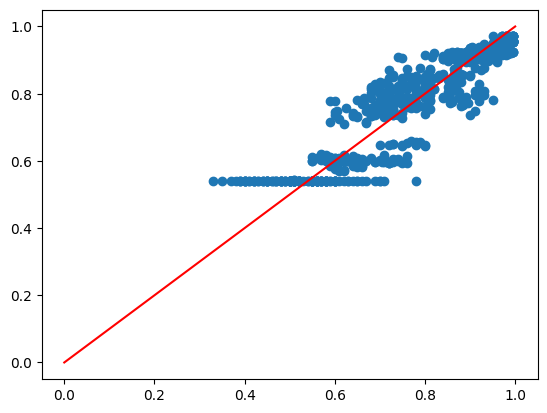

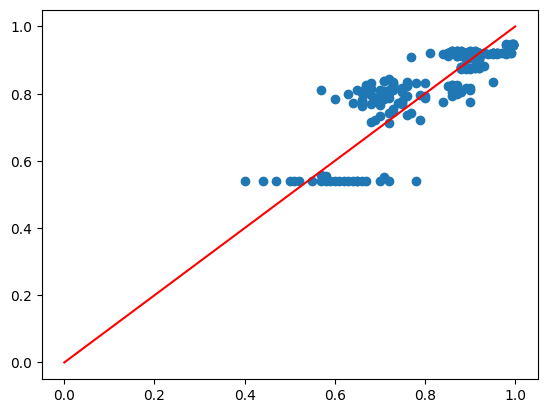

In [71]:
t3 = Trainer(model, device, optimizer, scheduler, glob_v= False)
t3.train(train_loader, val_loader, nn.BCELoss, EPOCHS)

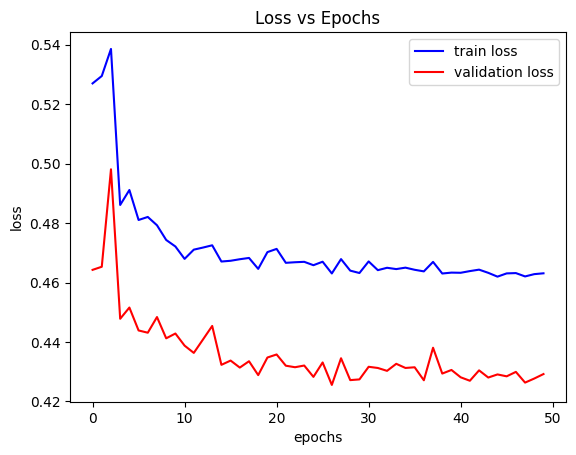

In [72]:
t3.plot_log()

In [80]:
t2.log.keys()

dict_keys(['train_loss', 'val_loss'])

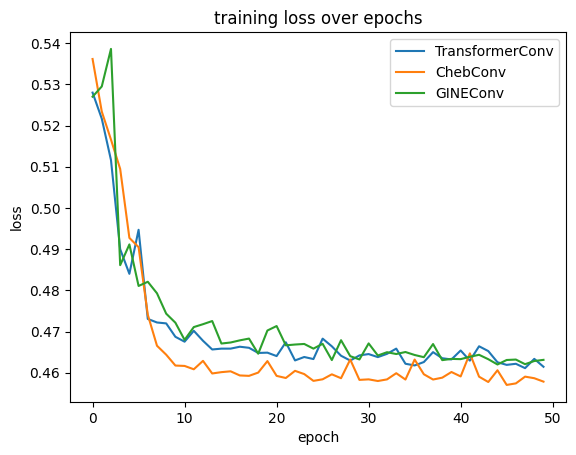

In [79]:
epoch_arr = range(50)
plt.plot(epoch_arr, t.log["train_loss"], label="TransformerConv")
plt.plot(epoch_arr, t2.log["train_loss"], label="ChebConv")
plt.plot(epoch_arr, t3.log["train_loss"], label="GINEConv")
plt.legend()
plt.title("training loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

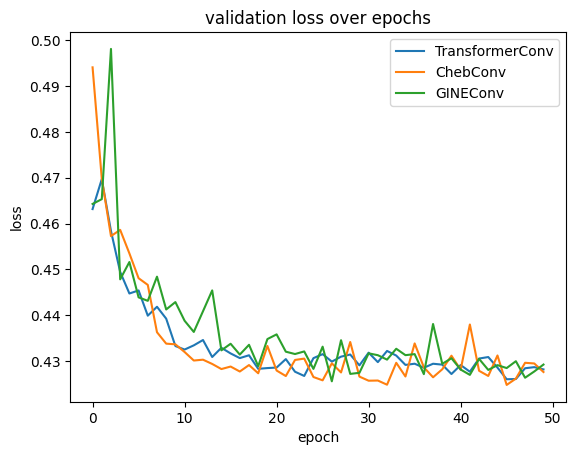

In [81]:
epoch_arr = range(50)
plt.plot(epoch_arr, t.log["val_loss"], label="TransformerConv")
plt.plot(epoch_arr, t2.log["val_loss"], label="ChebConv")
plt.plot(epoch_arr, t3.log["val_loss"], label="GINEConv")
plt.legend()
plt.title("validation loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()